# **SETUP AND INSTALLATIONS**

In [1]:
from google.colab import drive
drive.mount("/content/MyDrive")

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [2]:
!pip install -q fastbook

In the notebook, we have three 'algorithms' in the ring -

* Average Baseline
* RandomForest
* ResNet-18

All of them are aiming for the top spot at the simple task of classifying 3 and 7. Of course, it is not MNIST but Kannada MNIST.

# **PREMISE**
This notebook explores the performance of baseline, random forest and resnet on the 3s vs 7s. 

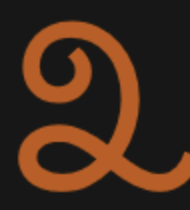


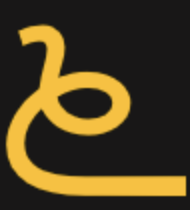


## **TL;DR** : Random forests FTW!
However, the neural network has just been fine tuned for 5 epochs and reaches close performance. So, quite promising. Not a dependable conclusion. ;-)

### **Imports**

In [3]:
#Pandas and Numpy
import numpy as np
import pandas as pd

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

#Fastai
from fastai.vision.all import *

#Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

To make sure everyone is working on the same dataset and the results are consistent amongst runs, we seed everything and then split the data at once. 

Also, not using the test set that is present in the dataset since it is not labelled.

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [5]:
train_df = pd.read_csv("kannada_mnist/train.csv")
only_37_df = train_df[train_df['label'].isin([3,7])]

train_37_df, test_37_df = train_test_split(only_37_df, test_size=0.2, random_state=42)

#### **SECTION-1** : The average baseline

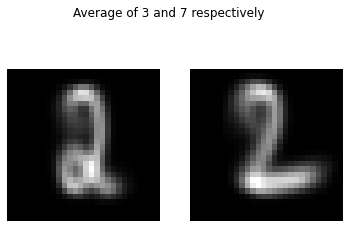

In [6]:
#Calculating means
mean3 = (train_37_df[train_37_df['label'] == 3]
            .iloc[:,1:]
            .mean().values.astype('uint8'))/255
mean7 = (train_37_df[train_37_df['label'] == 7]
            .iloc[:,1:]
            .mean().values.astype('uint8'))/255

#Checking the plot
im3 = mean3.reshape((28,28))*255           
im7 = mean7.reshape((28,28))*255
fig, ax = plt.subplots(1,2)
ax[0].axis('off');ax[1].axis('off')
fig.suptitle('Average of 3 and 7 respectively')
ax[0].imshow(im3, cmap="gray"); ax[1].imshow(im7, cmap="gray");

In [7]:
threes = test_37_df[test_37_df['label'] == 3].iloc[:,1:].values/255
sevens = test_37_df[test_37_df['label'] == 7].iloc[:,1:].values/255

mnist_distance = lambda x, y: np.sqrt(np.mean((x-y)**2, axis=1))
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)
accuracy_3s =      is_3(threes).mean()
accuracy_7s = (1 - is_3(sevens)).mean()

print(f"AVERAGE BASELINE accuracy is {(accuracy_3s+accuracy_7s)*100/2:.2f}%")

AVERAGE BASELINE accuracy is 91.50%


#### **SECTION-2** : RandomForest

In [8]:
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(train_37_df.iloc[:,1:-1],train_37_df.iloc[:,0])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [9]:
predictions = rf.predict(test_37_df.iloc[:,1:-1])
actuals = test_37_df.iloc[:,0].values

In [10]:
accuracy = accuracy_score(actuals, predictions)
print (f"RANDOM FOREST accuracy is {accuracy*100:.2f}%")

RANDOM FOREST accuracy is 98.58%


#### **SECTION-3** : Resnet-18

In [11]:
def read_row(x): return x.values
def get_img_row(x): return x[1:].reshape(28,28).astype('uint8')
def get_label(x): return x[0]

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=read_row,
                   get_x=get_img_row,
                   get_y=get_label)

dls = dblock.dataloaders(train_37_df)
xb, yb = dls.one_batch()

print (xb.shape, yb.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


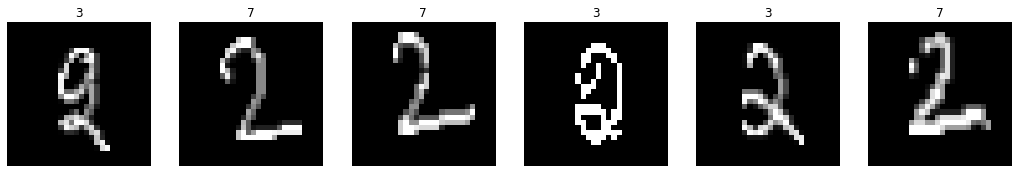

In [12]:
dls.show_batch(max_n=6,nrows=1,cmap="gray")

In [13]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5, base_lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,0.890105,0.577663,0.240104,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.471535,0.223593,0.091146,00:13
1,0.164719,0.081823,0.031250,00:13
2,0.076662,0.059725,0.021875,00:13
3,0.044019,0.045784,0.014583,00:13
4,0.023431,0.049939,0.015625,00:13


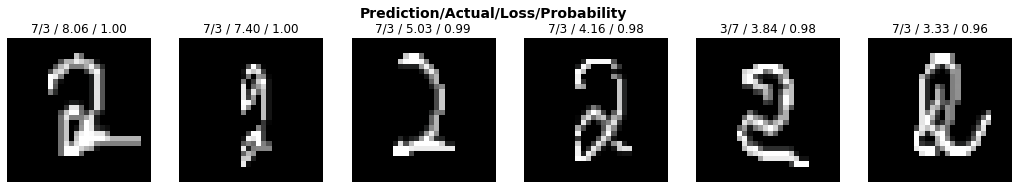

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(6, nrows=1)

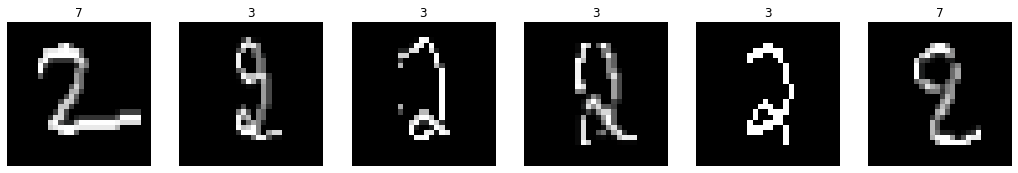

In [15]:
test_data = test_37_df.values
test_dl = learn.dls.test_dl(test_data, with_labels=True)
test_dl.show_batch(max_n=6,nrows=1,cmap="gray")

In [16]:
pred_tensor, _, preds = learn.get_preds(dl=test_dl, with_decoded=True)

In [17]:
predicted_val = [test_dl.vocab[i] for i in preds]
actual_val = test_37_df['label'].values.tolist()

accuracy = accuracy_score(actual_val, predicted_val)
print (f"RESNET-18 accuracy is {accuracy*100:.2f}%")

RESNET-18 accuracy is 97.62%
